In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from ase.io import read
import torch
from tqdm import tqdm
from glob import glob
from pathlib import Path
from itertools import product
from mace import data, tools
from mace.tools import torch_geometric
from mace.tools.torch_tools import to_numpy
from contextlib import contextmanager


sns.set_theme(style="whitegrid")

In [3]:
test_files = sorted(glob("/home/hatemh/BOTNet-datasets/dataset_3BPA/test_*"))
checkpoint_files = sorted(glob("/home/hatemh/mace/experiments/checkpoints/*.model"))
num_tests = len(test_files)
num_checkpoints = len(checkpoint_files)
total_combinations = num_tests * num_checkpoints
total_combinations

96

In [4]:
z_table = tools.utils.AtomicNumberTable([1, 6, 7, 8])
r_max = 5.0
device = "cuda"

In [5]:
def parse_clip_grad(name: str):
    part = list(filter(lambda x: x.startswith("cg"), name.split("_")))

    if len(part) == 0:
        return -1

    return float(part[0].split("-")[-1])


def parse_loss_scale(name: str):
    part = list(filter(lambda x: x.startswith("ls"), name.split("_")))

    if len(part) == 0:
        return 1.0

    return float(part[0].split("-")[-1])


def parse_values(checkpoint_file: str):
    name = Path(checkpoint_file).stem
    seed = int(name.split("-")[-1])
    dtype = "float32" if name.find("fp64") == -1 else "float64"
    clip_grad = parse_clip_grad(name)
    loss_scale = parse_loss_scale(name)
    return {
        "seed": seed,
        "dtype": dtype,
        "clip_grad": clip_grad,
        "loss_scale": loss_scale,
    }


def make_loader(file: str):
    atoms_list = read(file, index=":")
    configs = data.utils.config_from_atoms_list(atoms_list)
    dataset = [
        data.AtomicData.from_config(c, z_table=z_table, cutoff=r_max) for c in configs
    ]
    loader = torch_geometric.dataloader.DataLoader(
        dataset=dataset, batch_size=32, shuffle=False, drop_last=False
    )
    return loader


@contextmanager
def default_dtype(dtype: torch.dtype):
    init = torch.get_default_dtype()
    torch.set_default_dtype(dtype)
    yield
    torch.set_default_dtype(init)


def eval_model(checkpoint_file: str, test_file: str, device: str = device):
    model = torch.load(checkpoint_file)
    model.to(device)
    model_dtype = {p.dtype for p in model.parameters()}.pop()

    with default_dtype(model_dtype):
        loader = make_loader(test_file)
        errors = []

        for batch in tqdm(loader):
            batch = batch.to(device)
            target = to_numpy(batch.energy)
            output = model(batch.to_dict())
            pred = to_numpy(output["energy"])
            errors.append(np.abs(target - pred))
        
    del model
    del loader
    torch.cuda.empty_cache()
    
    errors = 1e3 * np.concatenate(errors, axis=0)
        
    
    return {
        **parse_values(checkpoint_file),
        "dataset": Path(test_file).stem,
        "mae (meV)": np.mean(errors),
        "rmse (meV)": np.sqrt(np.mean(errors**2)),
    }

In [6]:
records = [
    eval_model(cf, tf)
    for cf, tf in tqdm(product(checkpoint_files, test_files), total=total_combinations)
]
df = pd.DataFrame(records)
df

100%|██████████| 96/96 [49:34<00:00, 30.99s/it]


,seed,dtype,clip_grad,loss_scale,dataset,mae (meV),rmse (meV)
0,1702,float32,10.0,1.0,test_1200K,34.625736,49.534935
1,1702,float32,10.0,1.0,test_300K,3.413580,5.112343
2,1702,float32,10.0,1.0,test_600K,8.639244,13.212955
3,1702,float32,10.0,1.0,test_dih,13.687396,36.273258
4,285,float32,10.0,1.0,test_1200K,44.702732,62.189041
...,...,...,...,...,...,...,...
91,285,float32,-1.0,1.0,test_dih,7.106304,16.125027
92,43,float32,-1.0,1.0,test_1200K,24.524092,35.421421
93,43,float32,-1.0,1.0,test_300K,5.227447,6.760247
94,43,float32,-1.0,1.0,test_600K,8.650207,13.371348


In [7]:
sweep_results = df.groupby(["dtype", "clip_grad", "loss_scale", "dataset"])["rmse (meV)"].describe()
sweep_results.sort_values(by=["mean"])

count        mean        std  \
dtype   clip_grad loss_scale dataset                                    
float64 -1.0      1000.0     test_300K     3.0    4.957189   0.984851   
                  1.0        test_300K     3.0    5.015252   0.596109   
float32 -1.0      1000.0     test_300K     3.0    5.471029   0.629171   
                  1.0        test_300K     3.0    5.534762   1.539809   
float64  10.0     1.0        test_300K     3.0    6.292116   1.778453   
float32  10.0     1.0        test_300K     3.0    6.877461   2.222139   
float64 -1.0      1.0        test_dih      3.0   10.877778   1.550219   
                  1000.0     test_dih      3.0   10.948316   1.433837   
float32 -1.0      1000.0     test_600K     3.0   12.327121   0.768050   
                  1.0        test_600K     3.0   12.445140   1.203852   
float64 -1.0      1000.0     test_600K     3.0   12.486919   0.906060   
                  1.0        test_600K     3.0   12.492463   0.676730   
         10.0     1.0        test_600K     3.0   13.846530   0.846099   
float32  10.0     1.0        test_600K     3.0   14.187050   1.236314   
        -1.0      1.0        test_dih      3.0   15.341333   3.734465   
                  1000.0     test_dih      3.0   16.511127   3.330929   
float64  10.0     1.0        test_dih      3.0   31.910917   2.751330   
float32  10.0     1.0        test_dih      3.0   34.649513   2.492315   
float64 -1.0      1.0        test_1200K    3.0   35.602469   2.826335   
                  1000.0     test_1200K    3.0   35.653489   2.607317   
float32 -1.0      1.0        test_1200K    3.0   36.033312   0.552034   
                  1000.0     test_1200K    3.0   37.058509   0.886400   
         10.0     1000.0     test_300K     3.0   45.729066   6.721403   
                             test_600K     3.0   48.588487   6.400582   
float64  10.0     1.0        test_1200K    3.0   55.751786   7.804372   
float32  10.0     1.0        test_1200K    3.0   60.174970   9.789639   
float64  10.0     1000.0     test_300K     3.0   60.593296   9.295712   
                             test_600K     3.0   62.638916   9.950036   
float32  10.0     1000.0     test_dih      3.0   70.192861   2.035071   
float64  10.0     1000.0     test_dih      3.0   78.825798  11.437241   
float32  10.0     1000.0     test_1200K    3.0  104.898043  10.091487   
float64  10.0     1000.0     test_1200K    3.0  110.275832  13.866519   

                                               min         25%         50%  \
dtype   clip_grad loss_scale dataset                                         
float64 -1.0      1000.0     test_300K    4.014803    4.445974    4.877144   
                  1.0        test_300K    4.425874    4.713942    5.002009   
float32 -1.0      1000.0     test_300K    4.773877    5.208226    5.642576   
                  1.0        test_300K    3.806381    4.922020    6.037659   
float64  10.0     1.0        test_300K    4.550510    5.385545    6.220580   
float32  10.0     1.0        test_300K    5.112343    5.629774    6.147205   
float64 -1.0      1.0        test_dih     9.901228    9.984037   10.066846   
                  1000.0     test_dih    10.033759   10.122061   10.210363   
float32 -1.0      1000.0     test_600K   11.442189   12.080528   12.718867   
                  1.0        test_600K   11.084336   11.982036   12.879735   
float64 -1.0      1000.0     test_600K   11.549965   12.051103   12.552242   
                  1.0        test_600K   11.760433   12.191067   12.621701   
         10.0     1.0        test_600K   13.061536   13.398427   13.735318   
float32  10.0     1.0        test_600K   13.212955   13.491633   13.770312   
        -1.0      1.0        test_dih    11.277212   13.701119   16.125027   
                  1000.0     test_dih    13.151467   14.860409   16.569351   
float64  10.0     1.0        test_dih    29.859738   30.347608   30.835479   
float32  10.0     1.0        test_dih    31.779917   33.837640   35.895363  

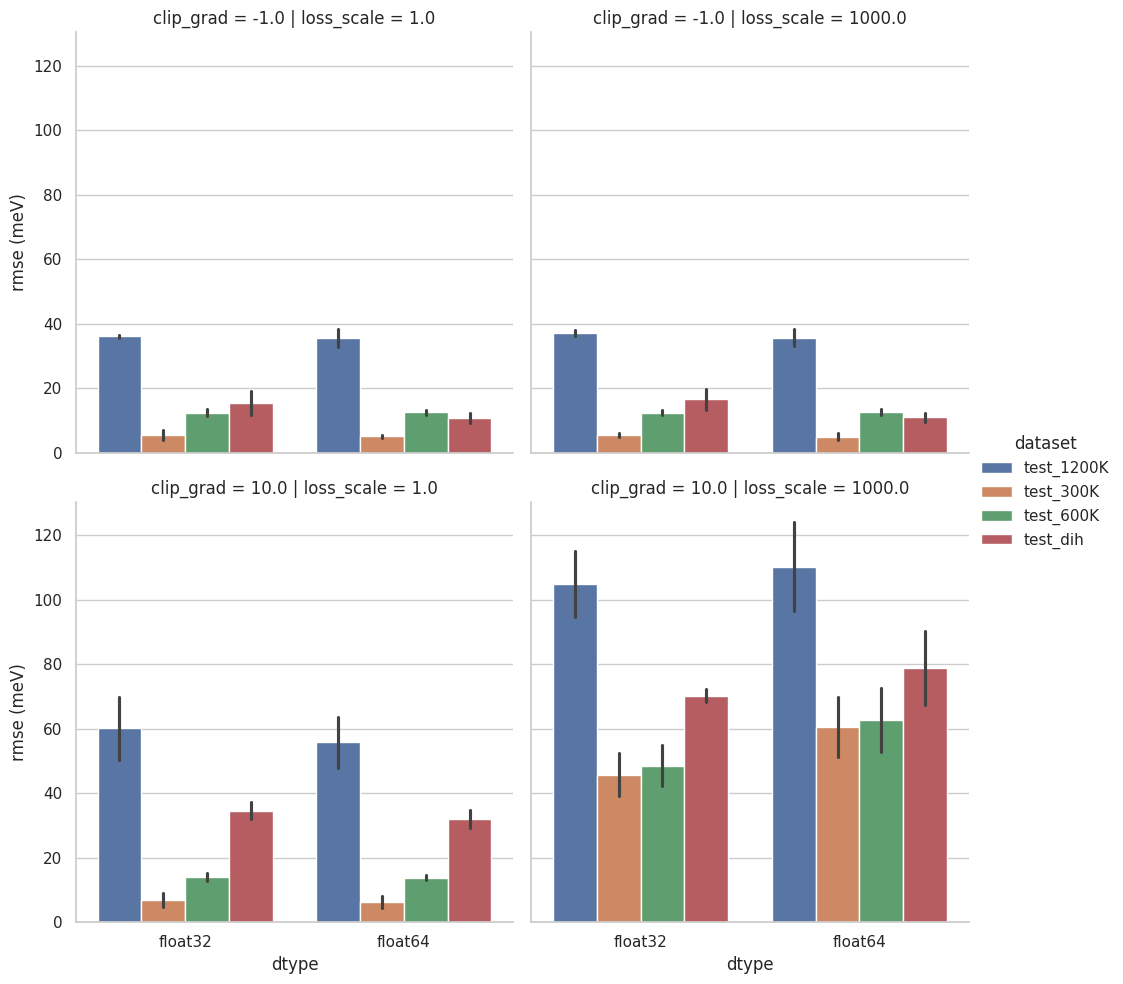

In [4]:
df = pd.read_parquet("eval_mace_sweep.parquet")
sns.catplot(
    data=df,
    x="dtype",
    y="rmse (meV)",
    col="loss_scale",
    row="clip_grad",
    hue="dataset",
    kind="bar",
    errorbar="sd",
)

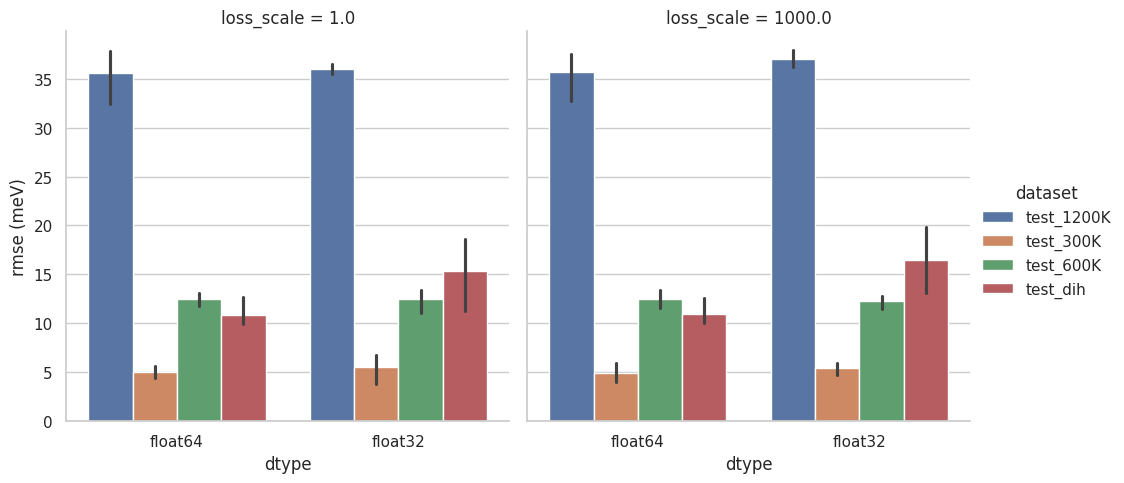

In [9]:
mask = (df["clip_grad"] == -1)
sns.catplot(data=df[mask], x="dtype", y="rmse (meV)", hue="dataset", col="loss_scale", kind="bar")